In [1]:
from itertools import combinations
import datetime
from math import ceil

import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import zuko
from tqdm import tqdm
import seaborn as sns
import cartopy.crs as ccrs
import cartopy
from matplotlib import animation

import bayes_air.utils.dataloader as ba_dataloader
from bayes_air.model import air_traffic_network_model
from bayes_air.network import NetworkState
from bayes_air.schedule import parse_schedule

sns.set(style="white", context="notebook", color_codes=True)
matplotlib.rcParams["figure.dpi"] = 100

In [2]:
# Load the data
top_n = 10
n_failure = 4
n_nominal = 5
n_calibration_permutations = 1
include_cancellations = True
per_point = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# Load the data
df = pd.read_pickle("../../../data/wn_data_clean_mst.pkl")
df = ba_dataloader.top_N_df(df, top_n)
nominal_df, disrupted_df = ba_dataloader.split_nominal_disrupted_data(df)
nominal_dfs = ba_dataloader.split_by_date(nominal_df)
disrupted_dfs = ba_dataloader.split_by_date(disrupted_df)

# Get just the set of data we want to study
nominal = nominal_dfs[-n_nominal:]

if not per_point:
    failure = disrupted_dfs[: 2 * n_failure : 2]
    n_failure_eval = n_failure
    failure_eval = disrupted_dfs[1 : 1 + n_failure : 2]
else:
    failure = disrupted_dfs[:n_failure]
    n_failure_eval = 1
    failure_eval = disrupted_dfs[:n_failure_eval]
    n_calibration_permutations = n_failure

# Filter out cancellations if we're not using them
if not include_cancellations:
    nominal = [df[~df["cancelled"]] for df in nominal]
    failure = [df[~df["cancelled"]] for df in failure]
    failure_eval = [df[~df["cancelled"]] for df in failure_eval]

# Convert each day into a schedule
nominal_states = []
failure_states = []
failure_eval_states = []

for day_df in nominal:
    flights, airports = parse_schedule(day_df, device=device)

    state = NetworkState(
        airports={airport.code: airport for airport in airports},
        pending_flights=flights,
    )
    nominal_states.append(state)

for day_df in failure:
    flights, airports = parse_schedule(day_df, device=device)

    state = NetworkState(
        airports={airport.code: airport for airport in airports},
        pending_flights=flights,
    )
    failure_states.append(state)

for day_df in failure_eval:
    flights, airports = parse_schedule(day_df, device=device)

    state = NetworkState(
        airports={airport.code: airport for airport in airports},
        pending_flights=flights,
    )
    failure_eval_states.append(state)

# Get some information about the network that will be needed to map
# the vector posterior to the sample sites in the probabilistic model
airport_codes = list(nominal_states[0].airports.keys())
n_airports = len(airport_codes)
pairs = list(combinations(airport_codes, 2))
n_latent_variables = (
    n_airports  # mean turnaround time for each airport
    + n_airports  # mean service time for each airport
    + n_airports * n_airports  # travel time between each pair of airports
)
if include_cancellations:
    n_latent_variables += n_airports  # log # of initial aircraft for each airport
    n_latent_variables += n_airports  # baseline cancel prob for each airport

# Get the total number of departures for each airport
num_departures = {
    code: sum([(day_df.origin_airport == code).sum() for day_df in failure])
    for code in airport_codes
}
airports_sorted_by_departures = sorted(
    airport_codes, key=lambda code: num_departures[code], reverse=True
)
original_palette = sns.color_palette("pastel")
airports_sorted_by_departures

['DEN', 'DAL', 'MDW', 'PHX', 'HOU', 'LAS', 'MCO', 'BNA', 'BWI', 'OAK']

In [3]:
print(min([len(s.pending_flights) for s in nominal_states]))
print(max([len(s.pending_flights) for s in nominal_states]))

433
497


In [4]:
# Define plotting functions
def map_to_sample_sites(sample):
    """Map vectorized samples to sample sites in the probabilistic model."""
    # Handle batched samples
    single_sample = len(sample.shape) == 1
    if single_sample:
        sample = sample.unsqueeze(0)

    assert sample.shape[-1] == n_latent_variables

    # Reshape & reparameterize the sample to satisfy positivity constraints
    airport_turnaround_times = torch.exp(sample[:, :n_airports])
    airport_service_times = torch.exp(sample[:, n_airports : 2 * n_airports])
    if include_cancellations:
        log_airport_initial_available_aircraft = sample[
            :, 2 * n_airports : 3 * n_airports
        ]
        log_airport_base_cancel_prob = sample[:, 3 * n_airports : 4 * n_airports]
        travel_times = torch.exp(
            sample[:, 4 * n_airports :].reshape(-1, n_airports, n_airports)
        )
    else:
        travel_times = torch.exp(
            sample[:, 2 * n_airports :].reshape(-1, n_airports, n_airports)
        )

    # Map to sample sites in the model
    conditioning_dict = {}
    for i, code in enumerate(airport_codes):
        conditioning_dict[f"{code}_mean_turnaround_time"] = airport_turnaround_times[
            :, i
        ]
        conditioning_dict[f"{code}_mean_service_time"] = airport_service_times[:, i]
        if include_cancellations:
            conditioning_dict[
                f"{code}_log_initial_available_aircraft"
            ] = log_airport_initial_available_aircraft[:, i]
            conditioning_dict[
                f"{code}_base_cancel_logprob"
            ] = log_airport_base_cancel_prob[:, i]

    for i, origin in enumerate(airport_codes):
        for j, destination in enumerate(airport_codes):
            if origin != destination:
                conditioning_dict[f"travel_time_{origin}_{destination}"] = travel_times[
                    :, i, j
                ]

    # Remove the batch dimension if it wasn't there before
    if single_sample:
        conditioning_dict = {
            key: value.squeeze(0) for key, value in conditioning_dict.items()
        }

    return conditioning_dict


@torch.no_grad()
def plot_travel_times(*sample_maps, labels=None):
    # Make subplots for each travel time pair
    rows = n_airports
    subplot_spec = []
    for i in range(rows):
        subplot_spec.append([f"{i},{j}" for j in range(rows)])

    fig = plt.figure(figsize=(4 * rows, 4 * rows))
    axs = fig.subplot_mosaic(subplot_spec, sharex=True, sharey=True)

    already_plotted = set()

    for i, origin in enumerate(airport_codes):
        for j, dest in enumerate(airport_codes):
            if origin == dest or (origin, dest) in already_plotted:
                axs[f"{i},{j}"].axis("off")
                continue

            already_plotted.add((origin, dest))
            already_plotted.add((dest, origin))

            for k, sample_map in enumerate(sample_maps):
                axs[f"{i},{j}"].scatter(
                    sample_map[f"travel_time_{origin}_{dest}"].cpu(),
                    sample_map[f"travel_time_{dest}_{origin}"].cpu(),
                    marker=".",
                    s=1,
                    label=labels[k] if labels else None,
                )

            axs[f"{i},{j}"].set_xlim(0, 8)
            axs[f"{i},{j}"].set_ylim(0, 8)
            axs[f"{i},{j}"].set_xlabel(f"{origin} -> {dest} travel time (hr)")
            axs[f"{i},{j}"].set_ylabel(f"{dest} -> {origin} travel time (hr)")
            axs[f"{i},{j}"].legend()

    fig.tight_layout()

    return fig


@torch.no_grad()
def plot_initial_aircraft(*sample_maps, labels=None):
    # Make subplots for each airport
    max_rows = 2
    max_plots_per_row = ceil(n_airports / max_rows)
    subplot_spec = []
    for i in range(max_rows):
        subplot_spec.append(
            [f"{i * max_plots_per_row +j}" for j in range(max_plots_per_row)]
        )

    fig = plt.figure(figsize=(4 * max_plots_per_row, 4 * max_rows))
    axs = fig.subplot_mosaic(subplot_spec)

    for i, code in enumerate(airport_codes):
        for j, sample_map in enumerate(sample_maps):
            axs[f"{i}"].hist(
                torch.exp(sample_map[f"{code}_log_initial_available_aircraft"]).cpu(),
                bins=64,
                density=True,
                label=labels[j] if labels else None,
                alpha=1 / len(sample_maps),
            )

        axs[f"{i}"].set_xlabel(f"{code} aircraft reserve")
        x_min, x_max = axs[f"{i}"].get_xlim()
        x_min = min(x_min, -0.05)
        x_max = max(x_max, 30)
        axs[f"{i}"].set_xlim(x_min, x_max)
        axs[f"{i}"].legend()

    return fig


@torch.no_grad()
def plot_base_cancel_prob(*sample_maps, labels=None):
    # Make subplots for each airport
    max_rows = 2
    max_plots_per_row = ceil(n_airports / max_rows)
    subplot_spec = []
    for i in range(max_rows):
        subplot_spec.append(
            [f"{i * max_plots_per_row +j}" for j in range(max_plots_per_row)]
        )

    fig = plt.figure(figsize=(4 * max_plots_per_row, 4 * max_rows))
    axs = fig.subplot_mosaic(subplot_spec)

    for i, code in enumerate(airport_codes):
        for j, sample_map in enumerate(sample_maps):
            axs[f"{i}"].hist(
                torch.exp(sample_map[f"{code}_base_cancel_logprob"]).cpu(),
                bins=64,
                density=True,
                label=labels[j] if labels else None,
                alpha=1 / len(sample_maps),
            )

        axs[f"{i}"].set_xlabel(f"{code} cancel prob")
        axs[f"{i}"].set_xlim(-0.05, 1.0)
        axs[f"{i}"].legend()

    return fig


@torch.no_grad()
def plot_service_times(*sample_maps, labels=None):
    # Make subplots for each airport
    max_rows = 2
    max_plots_per_row = ceil(n_airports / max_rows)
    subplot_spec = []
    for i in range(max_rows):
        subplot_spec.append(
            [f"{i * max_plots_per_row +j}" for j in range(max_plots_per_row)]
        )

    fig = plt.figure(figsize=(4 * max_plots_per_row, 4 * max_rows))
    axs = fig.subplot_mosaic(subplot_spec)

    for i, code in enumerate(airport_codes):
        for j, sample_map in enumerate(sample_maps):
            axs[f"{i}"].hist(
                sample_map[f"{code}_mean_service_time"].cpu(),
                bins=64,
                density=True,
                label=labels[j] if labels else None,
                alpha=1 / len(sample_maps),
            )

        axs[f"{i}"].set_xlabel(f"{code} service time (hr)")
        x_min, x_max = axs[f"{i}"].get_xlim()
        x_min = min(x_min, -0.05)
        x_max = max(x_max, 1.05)
        axs[f"{i}"].set_xlim(x_min, x_max)
        axs[f"{i}"].legend()

    return fig


@torch.no_grad()
def plot_turnaround_times(*sample_maps, labels=None):
    # Make subplots for each airport
    max_rows = 2
    max_plots_per_row = ceil(n_airports / max_rows)
    subplot_spec = []
    for i in range(max_rows):
        subplot_spec.append(
            [f"{i * max_plots_per_row +j}" for j in range(max_plots_per_row)]
        )

    fig = plt.figure(figsize=(4 * max_plots_per_row, 4 * max_rows))
    axs = fig.subplot_mosaic(subplot_spec)

    for i, code in enumerate(airport_codes):
        for j, sample_map in enumerate(sample_maps):
            axs[f"{i}"].hist(
                sample_map[f"{code}_mean_turnaround_time"].cpu(),
                bins=64,
                density=True,
                label=labels[j] if labels else None,
                alpha=1 / len(sample_maps),
            )

        axs[f"{i}"].set_xlabel(f"{code} turnaround time (hr)")
        x_min, x_max = axs[f"{i}"].get_xlim()
        x_min = min(x_min, -0.05)
        x_max = max(x_max, 1.05)
        # axs[f"{i}"].set_xlim(x_min, x_max)
        axs[f"{i}"].legend()

    return fig


@torch.no_grad()
def plot_posterior_grid(
    failure_guide,
    nominal_label,
):
    """Plot DEN service times on a grid"""
    n_steps = 2
    fig, axs = plt.subplots(
        n_steps,
        n_calibration_permutations,
        figsize=(5 * n_calibration_permutations, 5 * n_steps),
    )

    for row, j in enumerate(torch.linspace(0, 1, n_steps)):
        for i in range(n_calibration_permutations):
            label = torch.zeros(n_calibration_permutations).to(nominal_label.device)
            label[i] = j

            samples = failure_guide(label).sample((1000,))
            sample_map = map_to_sample_sites(samples)

            code = "DEN"
            axs[row, i].hist(
                sample_map[f"{code}_mean_service_time"].cpu(), bins=64, density=True
            )
            axs[row, i].set_xlabel(f"{code} service time (hr)")
            x_min, x_max = axs[row, i].get_xlim()
            x_min = min(x_min, -0.05)
            x_max = max(x_max, 1.05)
            axs[row, i].set_xlim(-0.05, 1.05)

    return fig

In [5]:
# Load the trained model
failure_guide = zuko.flows.NSF(
    features=n_latent_variables,
    context=n_calibration_permutations,
    hidden_features=(64, 64),
).to(device)
state_dict = torch.load("./models/top-10-daily-cancel-failure_checkpoint_499.pt")
failure_guide.load_state_dict(state_dict["failure_guide"])
mixture_label = state_dict["mixture_label"]
nominal_label = torch.zeros_like(mixture_label)
failure_guide.eval();

In [6]:
# Get some samples from each day
n_samples = 100
sample_maps = []
nominal_samples = failure_guide(nominal_label).sample((n_samples,))
nominal_sample_maps = map_to_sample_sites(nominal_samples)
for i in tqdm(range(n_failure)):
    label = torch.zeros_like(mixture_label).to(device)
    label[i] = 1
    failure_samples = failure_guide(label).sample((n_samples,))
    sample_maps.append(map_to_sample_sites(failure_samples))

100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


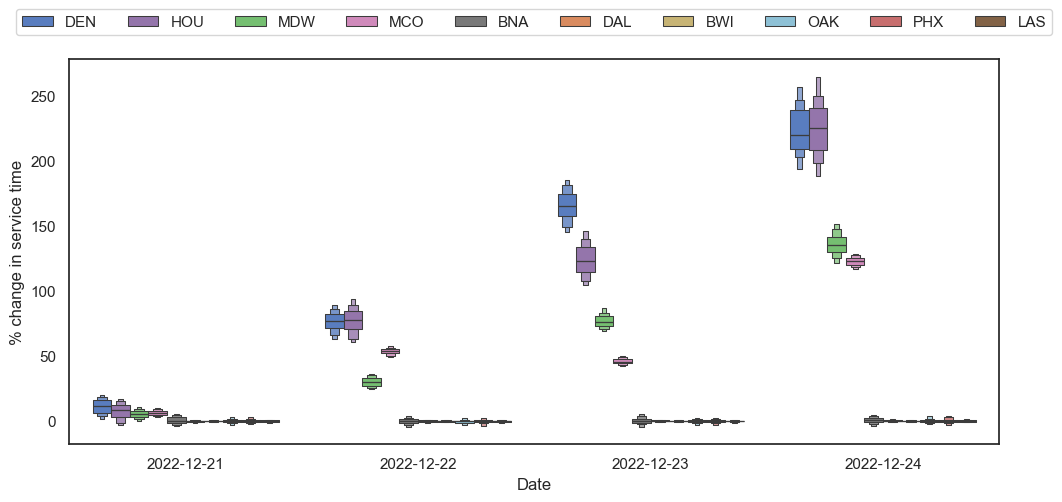

In [7]:
# Plot the service times for each airport over time
failure_airport_service_times = {}
nominal_airport_service_times = {}
for code in airport_codes:
    failure_airport_service_times[code] = torch.cat(
        [s[f"{code}_mean_service_time"].reshape(1, -1) for s in sample_maps], dim=0
    )
    nominal_airport_service_times[code] = nominal_sample_maps[
        f"{code}_mean_service_time"
    ]

mean_service_time = {
    code: failure_airport_service_times[code].cpu().mean() for code in airport_codes
}
relative_change_in_service_time = {
    code: (
        failure_airport_service_times[code].cpu().mean()
        - nominal_airport_service_times[code].cpu().mean()
    )
    / nominal_airport_service_times[code].cpu().mean()
    for code in airport_codes
}
codes_sorted_by_service_time = sorted(
    airport_codes, key=lambda code: relative_change_in_service_time[code], reverse=True
)

# Update the palette to keep colors consistent
palette = sns.color_palette()
palette = [
    sns.color_palette("muted")[airports_sorted_by_departures.index(code)]
    for code in codes_sorted_by_service_time
]
sns.set_palette(palette)

df = pd.DataFrame()

absolute = False
for code in codes_sorted_by_service_time:
    failure_dates = [f.date.unique()[0] for f in failure]
    failure_service_times = failure_airport_service_times[code].cpu().mean(dim=-1)
    nominal_dates = [pd.Timestamp(datetime.date(2022, 12, 20))]
    nominal_service_times = nominal_airport_service_times[code].cpu().mean(dim=-1)

    if absolute:
        airport_df = pd.DataFrame(
            {
                "Date": nominal_dates * n_samples
                + [d for d in failure_dates for _ in range(n_samples)],
                "Mean service time (hr)": torch.cat(
                    [
                        nominal_airport_service_times[code].cpu(),
                        failure_airport_service_times[code].cpu().reshape(-1),
                    ]
                ),
                "Period": ["nominal"] * n_samples
                + ["failure"] * n_samples * len(failure_dates),
                "Airport": [code] * (n_samples * (len(failure_dates) + 1)),
            }
        )
    else:
        relative_change = failure_airport_service_times[code].reshape(
            -1
        ) - nominal_airport_service_times[code].tile(n_failure)
        relative_change /= nominal_airport_service_times[code].tile(n_failure)
        relative_change *= 100
        relative_change = relative_change.cpu()
        airport_df = pd.DataFrame(
            {
                "Date": [d for d in failure_dates for _ in range(n_samples)],
                "% change in service time": relative_change,
                "Period": ["failure"] * n_samples * len(failure_dates),
                "Airport": [code] * n_samples * len(failure_dates),
            }
        )
    df = pd.concat([df, airport_df])

ylabel = "Mean service time (hr)" if absolute else "% change in service time"

plt.figure(figsize=(12, 5))
sns.boxenplot(x="Date", y=ylabel, hue="Airport", data=df, showfliers=False)
plt.legend(bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=len(airport_codes))

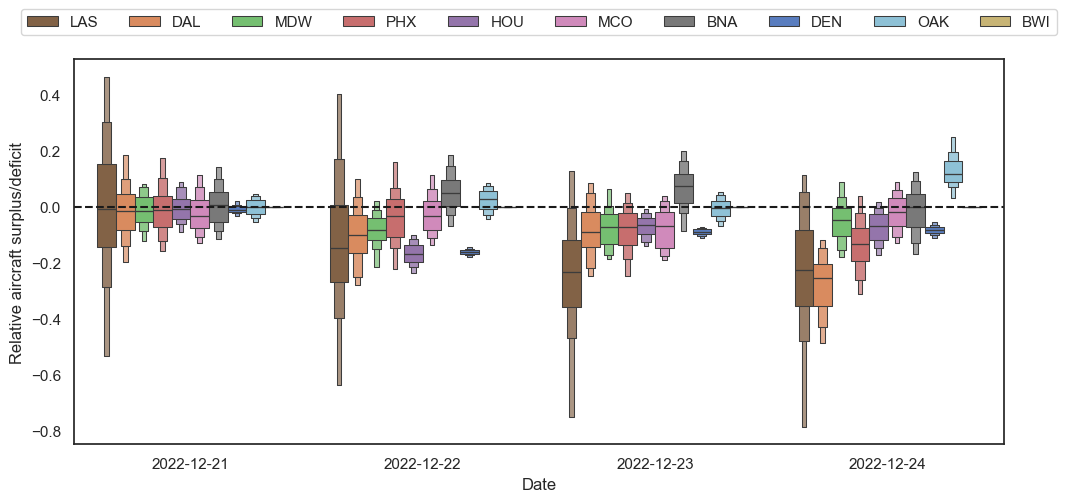

In [8]:
# Plot the available aircraft for each airport over time
failure_airport_aircraft = {}
nominal_airport_aircraft = {}
for code in airport_codes:
    failure_airport_aircraft[code] = torch.exp(
        torch.cat(
            [
                s[f"{code}_log_initial_available_aircraft"].reshape(1, -1)
                for s in sample_maps
            ],
            dim=0,
        )
    )
    nominal_airport_aircraft[code] = torch.exp(
        nominal_sample_maps[f"{code}_log_initial_available_aircraft"]
    )

mean_aircraft = {
    code: failure_airport_aircraft[code].cpu().mean() for code in airport_codes
}
codes_sorted_by_aircraft = sorted(
    airport_codes, key=lambda code: mean_aircraft[code], reverse=True
)

# Update the palette to keep colors consistent
palette = sns.color_palette()
palette = [
    sns.color_palette("muted")[airports_sorted_by_departures.index(code)]
    for code in codes_sorted_by_aircraft
]
sns.set_palette(palette)

df = pd.DataFrame()

absolute = False
for code in codes_sorted_by_aircraft:
    failure_dates = [f.date.unique()[0] for f in failure]
    failure_service_times = failure_airport_aircraft[code].cpu().mean(dim=-1)
    nominal_dates = [pd.Timestamp(datetime.date(2022, 12, 20))]
    nominal_service_times = nominal_airport_aircraft[code].cpu().mean(dim=-1)

    # Absolute
    if absolute:
        airport_df = pd.DataFrame(
            {
                "Date": nominal_dates * n_samples
                + [d for d in failure_dates for _ in range(n_samples)],
                "Available aircraft": torch.cat(
                    [
                        nominal_airport_aircraft[code].cpu(),
                        failure_airport_aircraft[code].cpu().reshape(-1),
                    ]
                ),
                "Period": ["nominal"] * n_samples
                + ["failure"] * n_samples * len(failure_dates),
                "Airport": [code] * (n_samples * (len(failure_dates) + 1)),
            }
        )
    else:
        # Relative
        aircraft_relative_to_nominal = (
            failure_airport_aircraft[code].reshape(-1)
            - nominal_airport_aircraft[code].tile(n_failure)
        ).cpu()
        num_departing_flights_per_day = (
            torch.tensor(
                [
                    (day_df.origin_airport == code).sum()
                    for day_df in failure
                    for _ in range(n_samples)
                ]
            )
            .float()
            .cpu()
        )
        aircraft_relative_to_nominal /= num_departing_flights_per_day
        airport_df = pd.DataFrame(
            {
                "Date": [d for d in failure_dates for _ in range(n_samples)],
                "Available aircraft / departures": aircraft_relative_to_nominal,
                "Period": ["failure"] * n_samples * len(failure_dates),
                "Airport": [code] * n_samples * len(failure_dates),
            }
        )
    df = pd.concat([df, airport_df])

ylabel = "Available aircraft" if absolute else "Available aircraft / departures"

plt.figure(figsize=(12, 5))
h = sns.boxenplot(x="Date", y=ylabel, hue="Airport", data=df, showfliers=False)
plt.legend(bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=len(airport_codes))
plt.axhline(0, color="k", linestyle="--")

if not absolute:
    plt.ylabel("Relative aircraft surplus/deficit")

# # Reorder the legend by departures
# handles, labels = plt.gca().get_legend_handles_labels()
# order = [labels.index(code) for code in airports_sorted_by_departures]

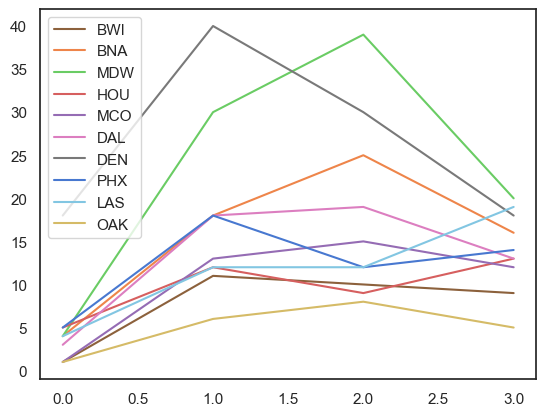

In [9]:
# How many flights were cancelled out of each airport on each day?
# cancelations = {[] for _ in airport_codes}

cancellations = [
    df.groupby("origin_airport").cancelled.sum().to_dict() for df in failure
]
cancellations = {code: [d[code] for d in cancellations] for code in airport_codes}
cancellations

for code in airport_codes:
    plt.plot(cancellations[code], label=code)
plt.legend()

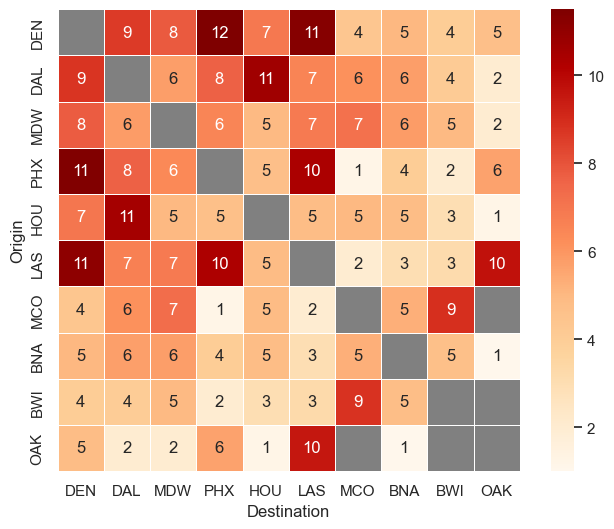

In [10]:
# Looking at the nominal period, where did the arriving flights come from?
flight_sources = (
    nominal_df[~nominal_df.cancelled]
    .groupby(["date", "destination_airport"])
    .origin_airport.value_counts()
)

# compute the mean across dates
nominal_flow_matrix = np.zeros((n_airports, n_airports))
for i, origin in enumerate(airports_sorted_by_departures):
    for j, destination in enumerate(airports_sorted_by_departures):
        if origin == destination:
            nominal_flow_matrix[i, j] = np.nan

        try:
            nominal_flow_matrix[i, j] = flight_sources[:, destination, origin].mean()
        except KeyError:
            pass

plt.figure(figsize=(8, 6))
plt.gca().set_facecolor("grey")
sns.heatmap(
    nominal_flow_matrix,
    xticklabels=airports_sorted_by_departures,
    yticklabels=airports_sorted_by_departures,
    cmap="OrRd",
    annot=True,
    fmt=".0f",
    square=True,
    linewidth=0.5,  # space between cells
)
plt.xlabel("Destination")
plt.ylabel("Origin")
plt.savefig("../../notebooks/images/wn_nominal_flow.png", dpi=300, bbox_inches="tight")

Text(101.25000000000009, 0.5, 'Origin')

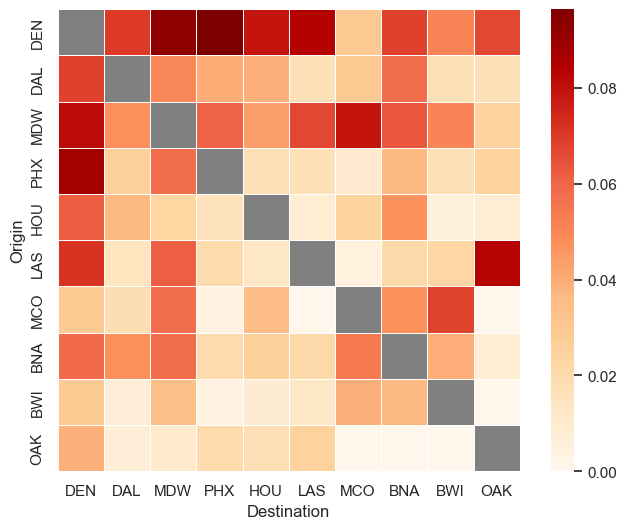

In [11]:
# Looking at the failure period, where did the arriving flights come from?
filtered_disrupted_df = disrupted_df[
    (disrupted_df.date <= pd.Timestamp(datetime.date(2022, 12, 25)))
    # & (disrupted_df.date > pd.Timestamp(datetime.date(2022, 12, 21)))
]
cancellations = (
    filtered_disrupted_df[filtered_disrupted_df.cancelled]
    .groupby(["date", "destination_airport"])
    .origin_airport.value_counts()
)
total_scheduled_arrivals = filtered_disrupted_df.groupby(
    ["date", "destination_airport"]
).flight_number.count()
total_scheduled_departures = filtered_disrupted_df.groupby(
    ["date", "origin_airport"]
).flight_number.count()

# compute the mean across dates
failure_flow_matrix = np.zeros((n_airports, n_airports))
for i, origin in enumerate(airports_sorted_by_departures):
    for j, destination in enumerate(airports_sorted_by_departures):
        if origin == destination:
            failure_flow_matrix[i, j] = np.nan
            continue

        try:
            failure_flow_matrix[i, j] = cancellations[:, destination, origin].sum()
            if np.isnan(failure_flow_matrix[i, j]):
                failure_flow_matrix[i, j] = 0

            failure_flow_matrix[i, j] /= total_scheduled_arrivals[:, destination].sum()
            # failure_flow_matrix[i, j] /= total_scheduled_departures[:, origin].sum()

        except KeyError:
            pass

plt.figure(figsize=(8, 6))
plt.gca().set_facecolor("grey")
sns.heatmap(
    failure_flow_matrix,
    xticklabels=airports_sorted_by_departures,
    yticklabels=airports_sorted_by_departures,
    cmap="OrRd",
    # annot=True,
    fmt=".2f",
    square=True,
    linewidth=0.5,  # space between cells
)
plt.xlabel("Destination")
plt.ylabel("Origin")
# plt.savefig(
#     "../../notebooks/images/wn_failure_flow_first_four_days.png",
#     dpi=300,
#     bbox_inches="tight",
# )

<Axes: xlabel='Date', ylabel='% incoming flights cancelled'>

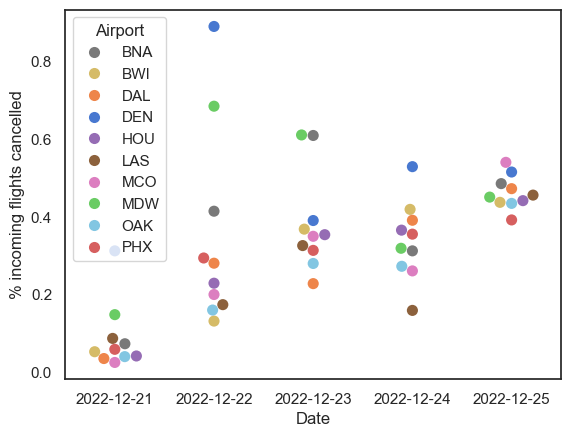

In [12]:
# Can we get the percentage of incoming flights cancelled by day?
cancellations = (
    filtered_disrupted_df[filtered_disrupted_df.cancelled]
    .groupby(["date", "destination_airport"])
    .origin_airport.count()
)
total_scheduled_arrivals = filtered_disrupted_df.groupby(
    ["date", "destination_airport"]
).flight_number.count()

pct_incoming_cancelled = cancellations / total_scheduled_arrivals
pct_incoming_cancelled = pct_incoming_cancelled.reset_index()
pct_incoming_cancelled.columns = ["Date", "Airport", "% incoming flights cancelled"]

# Update the palette to keep colors consistent
airport_list = list(pct_incoming_cancelled.Airport)
palette = sns.color_palette()
palette = [
    sns.color_palette("muted")[airports_sorted_by_departures.index(code)]
    for code in airport_list
]
sns.set_palette(palette)

sns.swarmplot(x="Date", y="% incoming flights cancelled", hue="Airport", data=pct_incoming_cancelled, size=8)

In [71]:
airports = {
    'BNA': (36.1245, -86.6781),  # Nashville International Airport
    'BWI': (39.1754, -76.6683),  # Baltimore/Washington International Thurgood Marshall Airport
    'DAL': (32.8969, -97.0372),  # Dallas Love Field
    'DEN': (39.8617, -104.6737), # Denver International Airport
    'HOU': (29.9844, -95.3414),  # William P. Hobby Airport
    'LAS': (36.0800, -115.1522), # Harry Reid International Airport
    'MCO': (28.4312, -81.3081),  # Orlando International Airport
    'MDW': (41.7867, -87.7525),  # Chicago Midway International Airport
    'OAK': (37.7212, -122.2208), # Oakland International Airport
    'PHX': (33.4341, -112.0119)  # Phoenix Sky Harbor International Airport
}
airport_df = pd.DataFrame.from_dict(airports, orient='index', columns=['latitude', 'longitude'])

cancellations = filtered_disrupted_df[filtered_disrupted_df.cancelled].copy()
cancellations["hour"] = cancellations.scheduled_departure_time.astype(int)
cancellations_by_date_and_hour = cancellations.groupby(["date", "hour", "origin_airport"]).flight_number.count()

aircraft_reserves = df.groupby(["Date", "Airport"])["Available aircraft / departures"].mean().copy()

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Add coastlines and states
ax.add_feature(cartopy.feature.OCEAN, color='lightblue')
# ax.add_feature(cartopy.feature.LAND, color='tan')
ax.set_extent([-125, -66.5, 24, 49], crs=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5)
ax.add_feature(cartopy.feature.STATES, linewidth=0.1)
ax.add_feature(cartopy.feature.BORDERS, linewidth=0.4)
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)

# Plot black dots for each airport
airport_cancel_scatters = {}
for airport, (lat, lon) in airports.items():
    airport_cancel_scatters[airport], = ax.plot(lon, lat, 'ko', markersize=4, transform=ccrs.PlateCarree())
    # ax.text(lon + 0.7, lat, airport, transform=ccrs.PlateCarree())

# Plot a small bar next to each airport to indicate the aircraft reserve
lons, lats = [], []
for airport in airport_codes:
    lat, lon = airports[airport]
    lons.append(lon)
    lats.append(lat)

lons = np.array(lons) - 1.0
lats = np.array(lats)
u = np.zeros_like(lons)
v = np.zeros_like(lats)
quiver = ax.quiver(lons, lats, u, v, scale=1, scale_units='xy', angles='xy', color='blue', transform=ccrs.PlateCarree(), headlength=3, headaxislength=3)

# Make a text box for the date and time
datestring = pd.Timestamp(datetime.date(2022, 12, 21)).strftime("%Y-%m-%d")
textbox = ax.text(-124, 50.5, f"{datestring} 0:00", transform=ccrs.PlateCarree(), fontsize=12, fontweight='bold', color='red')

def plot_map(time_info):
    print(time_info)
    date, hour, hour_fraction = time_info
    
    # Plot cancellations at each airport
    for airport in airport_codes:
        lat, lon = airports[airport]

        # Get the cancellations for the given date and hour
        if (date, hour, airport) in cancellations_by_date_and_hour.index:
            cancellations = cancellations_by_date_and_hour.loc[date, hour, airport]
        else:
            cancellations = 0.0
        
        if hour < 23:
            index = (date, hour + 1, airport)
            if index in cancellations_by_date_and_hour.index:
                cancellations_next_hour = cancellations_by_date_and_hour.loc[index]
            else:
                cancellations_next_hour = 0.0
        else:
            index = (date + pd.Timedelta(days=1), 0, airport)
            if index in cancellations_by_date_and_hour.index:
                cancellations_next_hour = cancellations_by_date_and_hour.loc[index]
            else:
                cancellations_next_hour = 0.0

        count = cancellations + hour_fraction * (cancellations_next_hour - cancellations)
        
        size = 4 + 20 * count / cancellations_by_date_and_hour.max()
        airport_cancel_scatters[airport].set_data([lon], [lat])
        airport_cancel_scatters[airport].set_markersize(size)

        if count == 0.0:
            airport_cancel_scatters[airport].set_color("black")
        else:
            airport_cancel_scatters[airport].set_color("red")

    # Plot the aircraft reserves
    reserves_smooth = []
    for airport in airport_codes:
        if (date, airport) in aircraft_reserves.index:
            reserve = aircraft_reserves.loc[date, airport]
        else:
            reserve = 0.0

        if date + pd.Timedelta(days=1) in aircraft_reserves.index:
            reserve_next_day = aircraft_reserves.loc[date + pd.Timedelta(days=1), airport]
        else:
            reserve_next_day = aircraft_reserves.loc[date, airport]

        day_fraction = (hour + hour_fraction) / 24
        reserve_smooth = reserve + day_fraction * (reserve_next_day - reserve)
        reserves_smooth.append(reserve_smooth)

    reserves_smooth = np.array(reserves_smooth)
    
    quiver.set_UVC(np.zeros_like(lons), reserves_smooth * 20)

    # Add text in the top left for the date and time
    datestring = date.strftime("%Y-%m-%d")
    hourstring = str(hour).zfill(2)
    time_string = f"{datestring} {hourstring}:{int(60 * hour_fraction):02d}"
    textbox.set_text(time_string)

    return fig, ax

dates = pd.date_range("2022-12-21", "2022-12-24", freq="D")
# dates = pd.date_range("2022-12-21", "2022-12-21", freq="D")
hours = range(24)
fractions = np.linspace(0, 1, 4)

time_inputs = [(date, hour, fraction) for date in dates for hour in hours for fraction in fractions]
ani = animation.FuncAnimation(
    fig, plot_map, frames=time_inputs, interval=50, repeat=False
)
ani.save("./cancellation_animation.mp4", writer="ffmpeg", dpi=300)
plt.close("all")

# plot_map((dates[1], 0, 0.0))
# fig

(Timestamp('2022-12-21 00:00:00'), 0, 0.0)
(Timestamp('2022-12-21 00:00:00'), 0, 0.0)
(Timestamp('2022-12-21 00:00:00'), 0, 0.3333333333333333)
(Timestamp('2022-12-21 00:00:00'), 0, 0.6666666666666666)
(Timestamp('2022-12-21 00:00:00'), 0, 1.0)
(Timestamp('2022-12-21 00:00:00'), 1, 0.0)
(Timestamp('2022-12-21 00:00:00'), 1, 0.3333333333333333)
(Timestamp('2022-12-21 00:00:00'), 1, 0.6666666666666666)
(Timestamp('2022-12-21 00:00:00'), 1, 1.0)
(Timestamp('2022-12-21 00:00:00'), 2, 0.0)
(Timestamp('2022-12-21 00:00:00'), 2, 0.3333333333333333)
(Timestamp('2022-12-21 00:00:00'), 2, 0.6666666666666666)
(Timestamp('2022-12-21 00:00:00'), 2, 1.0)
(Timestamp('2022-12-21 00:00:00'), 3, 0.0)
(Timestamp('2022-12-21 00:00:00'), 3, 0.3333333333333333)
(Timestamp('2022-12-21 00:00:00'), 3, 0.6666666666666666)
(Timestamp('2022-12-21 00:00:00'), 3, 1.0)
(Timestamp('2022-12-21 00:00:00'), 4, 0.0)
(Timestamp('2022-12-21 00:00:00'), 4, 0.3333333333333333)
(Timestamp('2022-12-21 00:00:00'), 4, 0.66666666